In [1]:
import sagemaker
from sagemaker.pytorch import PyTorchModel

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = sess.default_bucket()
model_artifact = sess.upload_data(
    path="softpatch_mvtec_all_classes.tar.gz",
    key_prefix="softpatch/models"
)
print("S3 model artifact:", model_artifact)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
S3 model artifact: s3://sagemaker-us-east-1-722396408893/softpatch/models/softpatch_mvtec_all_classes.tar.gz


In [ ]:
softpatch_model = PyTorchModel(
    model_data=model_artifact,
    role=role,
    framework_version="1.13",   # supported
    py_version="py39",          
    entry_point="inference_softpatch.py",
    source_dir=".",             # folder containing src/, inference file
)


In [9]:
endpoint_name = "softpatch-mvtec-all-classes"

predictor = softpatch_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    endpoint_name=endpoint_name,
)
print("Endpoint name:", endpoint_name)


----------!Endpoint name: softpatch-mvtec-all-classes


In [14]:
import json, base64
from pathlib import Path
import sagemaker
from sagemaker import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

ENDPOINT_NAME = "softpatch-mvtec-all-classes"

predictor = Predictor(
    endpoint_name=ENDPOINT_NAME,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

# Load an image
img_path = Path("/home/sagemaker-user/patchcore-inspection/mvtec/bottle/test/broken_large/000.png")
with open(img_path, "rb") as f:
    img_bytes = f.read()

payload = {
    "classname": "bottle",
    "image": base64.b64encode(img_bytes).decode("utf-8")
}

print("Sending request to endpoint:", ENDPOINT_NAME)
result = predictor.predict(payload)

print("\n===== RESULT =====")
print("Class:", result.get("classname"))
print("Anomaly score:", result.get("anomaly_score"))

heatmap = result.get("anomaly_heatmap")
if heatmap is not None:
    print("Heatmap size:", len(heatmap), "x", len(heatmap[0]))
else:
    print("No heatmap returned")


Sending request to endpoint: softpatch-mvtec-all-classes

===== RESULT =====
Class: bottle
Anomaly score: 6.364614486694336
Heatmap size: 224 x 224


In [3]:
import os, shutil

BASE_DIR = "/home/sagemaker-user/AnomalyDetection-SoftPatch"
os.chdir(BASE_DIR)

local_model_dir = "local_model_dir"

# Clean + recreate
if os.path.exists(local_model_dir):
    shutil.rmtree(local_model_dir)

os.makedirs(os.path.join(local_model_dir, "models"), exist_ok=True)

# Copy all mvtec_* models into local_model_dir/models
src_models_root = "result/project/group/models"
dst_models_root = os.path.join(local_model_dir, "models")

shutil.copytree(src_models_root, dst_models_root, dirs_exist_ok=True)

print("Local model_dir structure:")
for root, dirs, files in os.walk(local_model_dir):
    print(root, "-> dirs:", dirs, "files:", files)


Local model_dir structure:
local_model_dir -> dirs: ['models'] files: []
local_model_dir/models -> dirs: ['mvtec_bottle', 'mvtec_cable', 'mvtec_capsule', 'mvtec_carpet', 'mvtec_grid', 'mvtec_hazelnut', 'mvtec_leather', 'mvtec_metal_nut', 'mvtec_pill', 'mvtec_screw', 'mvtec_tile', 'mvtec_toothbrush', 'mvtec_transistor', 'mvtec_wood', 'mvtec_zipper'] files: []
local_model_dir/models/mvtec_bottle -> dirs: ['coreset_0'] files: ['meta.pkl']
local_model_dir/models/mvtec_bottle/coreset_0 -> dirs: [] files: ['nnscorer_search_index.faiss', 'params.pkl']
local_model_dir/models/mvtec_cable -> dirs: ['coreset_0'] files: ['meta.pkl']
local_model_dir/models/mvtec_cable/coreset_0 -> dirs: [] files: ['nnscorer_search_index.faiss', 'params.pkl']
local_model_dir/models/mvtec_capsule -> dirs: ['coreset_0'] files: ['meta.pkl']
local_model_dir/models/mvtec_capsule/coreset_0 -> dirs: [] files: ['nnscorer_search_index.faiss', 'params.pkl']
local_model_dir/models/mvtec_carpet -> dirs: ['coreset_0'] files: ['m

In [5]:
from inference_softpatch import model_fn, input_fn, predict_fn

model = model_fn(local_model_dir)
print("Loaded classes:", list(model["models_by_class"].keys()))


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded classes: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [ ]:
from inference_softpatch import model_fn, input_fn, predict_fn
import base64, json
from pathlib import Path

BASE_DIR = "/home/sagemaker-user/AnomalyDetection-SoftPatch"
local_model_dir = BASE_DIR + "/local_model_dir"  # the one you created before

model = model_fn(local_model_dir)
print("Loaded classes:", list(model["models_by_class"].keys()))

img_path = Path("/home/sagemaker-user/patchcore-inspection/mvtec/bottle/test/broken_large/000.png")
with open(img_path, "rb") as f:
    img_bytes = f.read()

payload = {
    "classname": "bottle",
    "image": base64.b64encode(img_bytes).decode("utf-8"),
}

request_body = json.dumps(payload)
input_data = input_fn(request_body, "application/json")
prediction = predict_fn(input_data, model)

print("Class:", prediction["classname"])
print("Anomaly score:", prediction["anomaly_score"])
print("Heatmap size:", len(prediction["anomaly_heatmap"]), "x", len(prediction["anomaly_heatmap"][0]))


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
import base64, json, requests

API_URL = "https://aeapulj2bf.execute-api.us-east-1.amazonaws.com/predict"

img_path = "../patchcore-inspection/mvtec/hazelnut/test/good/000.png"
with open(img_path, "rb") as f:
    img_bytes = f.read()

payload = {
    "class_name": "bottle",
    "image_base64": base64.b64encode(img_bytes).decode("utf-8"),
    "model": "softpatch"
}
resp = requests.post(API_URL, json=payload)
print(resp.status_code, resp.json())



200 {'anomaly_score': 8.249460220336914, 'class_name': 'bottle', 'model': 'softpatch', 'from_cache': False, 'anomaly_heatmap': [[2.046931505203247, 2.0596909523010254, 2.0850446224212646, 2.122554063796997, 2.1713340282440186, 2.2298924922943115, 2.296053171157837, 2.367009401321411, 2.4395248889923096, 2.510240316390991, 2.576030969619751, 2.634338617324829, 2.6834120750427246, 2.7224087715148926, 2.751347303390503, 2.7709364891052246, 2.782327890396118, 2.7868659496307373, 2.7858829498291016, 2.7805721759796143, 2.7719433307647705, 2.7608344554901123, 2.747955083847046, 2.7339298725128174, 2.7193257808685303, 2.704658269882202, 2.690384864807129, 2.6768932342529297, 2.664494276046753, 2.653428316116333, 2.6438801288604736, 2.635998487472534, 2.6299173831939697, 2.6257598400115967, 2.623629331588745, 2.6235883235931396, 2.625631093978882, 2.6296632289886475, 2.635498523712158, 2.6428704261779785, 2.6514604091644287, 2.660931348800659, 2.670959234237671, 2.681252956390381, 2.6915624141

In [18]:
len(base64.b64encode(img_bytes))


1675348

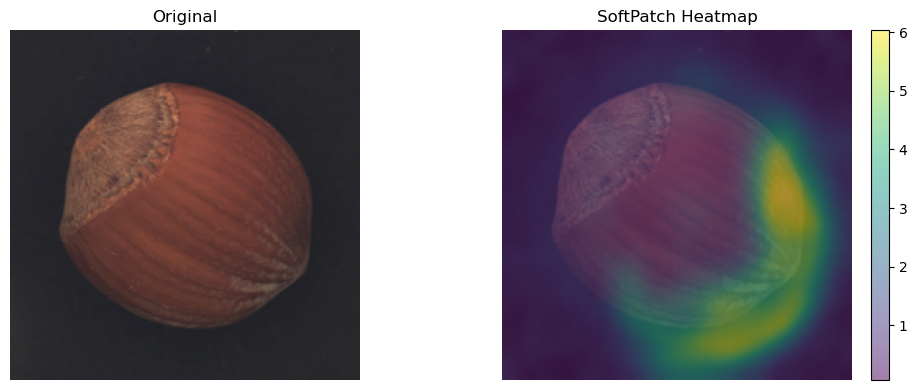

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# result = resp.json()
heatmap = np.array(result["anomaly_heatmap"], dtype=float)  # shape ~ (224, 224)

# load original image
img = Image.open(img_path).convert("RGB")
img = img.resize((heatmap.shape[1], heatmap.shape[0]))  # match size

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Original")
plt.axis("off")
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("SoftPatch Heatmap")
plt.axis("off")
plt.imshow(img)
plt.imshow(heatmap, alpha=0.5)  # overlay
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [30]:
import base64, json, requests, pathlib

API_URL = "https://aeapulj2bf.execute-api.us-east-1.amazonaws.com/predict"  # EXACT same as in HTML

img_path = pathlib.Path("../patchcore-inspection/mvtec/hazelnut/test/good/000.png")  # or any local image
with open(img_path, "rb") as f:
    img_bytes = f.read()

payload = {
    "class_name": "hazelnut",
    "image_base64": base64.b64encode(img_bytes).decode("utf-8"),
    "model": "patchcore"
}

r = requests.post(API_URL, json=payload)
print(r.status_code)
print(r.text)


200
{"anomaly_score": 2.7141027450561523, "class_name": "hazelnut", "model": "patchcore", "from_cache": true}


In [ ]:
import base64, json, requests

API_URL = "https://d3uifyxzuwz67a.cloudfront.net/predict"  #CloudFront url

img_path = "../patchcore-inspection/mvtec/hazelnut/test/good/000.png"
with open(img_path, "rb") as f:
    img_bytes = f.read()

payload = {
    "class_name": "hazelnut",
    "image_base64": base64.b64encode(img_bytes).decode("utf-8"),
    "model": "softpatch",  # or "softpatch"
}

resp = requests.post(
    API_URL,
    headers={"Content-Type": "application/json"},
    data=json.dumps(payload),
)

print("Status:", resp.status_code)
print("Body:", resp.json())


Status: 403


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.12/site-packages/requests/models.py:976 in json                           │
│                                                                                                  │
│    973 │   │   │   │   │   raise RequestsJSONDecodeError(e.msg, e.doc, e.pos)                    │
│    974 │   │                                                                                     │
│    975 │   │   try:                                                                              │
│ ❱  976 │   │   │   return complexjson.loads(self.text, **kwargs)                                 │
│    977 │   │   except JSONDecodeError as e:                                                      │
│    978 │   │   │   # Catch JSON-related errors and raise as requests.JSONDecodeError             │
│    979 │   │   │   # This aliases json.JSONDecodeError and simplejson.JSONDecodeError            │
│                                                                                                  │
│ /opt/conda/lib/python3.12/json/__init__.py:346 in loads                                          │
│                                                                                                  │
│   343 │   if (cls is None and object_hook is None and                                            │
│   344 │   │   │   parse_int is None and parse_float is None and                                  │
│   345 │   │   │   parse_constant is None and object_pairs_hook is None and not kw):              │
│ ❱ 346 │   │   return _default_decoder.decode(s)                                                  │
│   347 │   if cls is None:                                                                        │
│   348 │   │   cls = JSONDecoder                                                                  │
│   349 │   if object_hook is not None:                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.12/json/decoder.py:338 in decode                                          │
│                                                                                                  │
│   335 │   │   containing a JSON document).                                                       │
│   336 │   │                                                                                      │
│   337 │   │   """                                                                                │
│ ❱ 338 │   │   obj, end = self.raw_decode(s, idx=_w(s, 0).end())                                  │
│   339 │   │   end = _w(s, end).end()                                                             │
│   340 │   │   if end != len(s):                                                                  │
│   341 │   │   │   raise JSONDecodeError("Extra data", s, end)                                    │
│                                                                                                  │
│ /opt/conda/lib/python3.12/json/decoder.py:356 in raw_decode                                      │
│                                                                                                  │
│   353 │   │   try:                                                                               │
│   354 │   │   │   obj, end = self.scan_once(s, idx)                                              │
│   355 │   │   except StopIteration as err:                                                       │
│ ❱ 356 │   │   │   raise JSONDecodeError("Expecting value", s, err.value) from None               │
│   357 │   │   return obj, end                                                                    │
│   358                                                                                            │
╰────────────────────────────────────────────────────────────